In [1]:
import matplotlib.pyplot as plt;
from matplotlib.animation import FuncAnimation;
from matplotlib.patches import Ellipse;
import numpy as np;
from scipy.constants import c;
from scipy.interpolate import interp1d;
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter;
import sys; 
#sys.path.insert(0, "..\\..\\python\\"); # Windows
sys.path.insert(0, "../../python"); # Ubuntu
sys.path.insert(0, "../current_profiles");
from crystal import crystal
import current_profiles as cp;
from ebeam import ebeam;
from laser import laser;
from plotting import makefig;
import phase_retard as pr;
import thz;

In [2]:
# Bunch parameters:
sigz    = 5.2e-6;
sigt    = sigz / c;
dt      = sigt / 10;
N       = 8000;
t       = np.linspace(-N * dt / 2, N * dt / 2, N);
Q_drive = 1.5e-9;
Q_wit   = 0.5e-9;
z_off   = 150e-6;
r0      = 10e-3;
drive   = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : 0});
wit     = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r0, 'del_z' : z_off});
drive.get_Er(r0); 
wit.get_Er(r0);
Er      = drive.Er + wit.Er;
# Initialize crystals and their parameters
cry = crystal('gap');
d    = 100e-6; # m
nslice = 100;
j     = np.arange(1, nslice, 1);
dz    = d / nslice;
d_arr = (j - 0.5) * dz;
# Initialize probe
y0 = 800e-9; 
dy = 27e-9;
tp = 30e-15;
probe = laser({'y0' : y0, 'dy' : dy, 'tp' : tp});

In [3]:
FEr, f = thz.raw_field(drive.Er + wit.Er, drive.t);
Ec, tt = thz.cry_field(drive.t, FEr, f, d, probe, cry, nslice = nslice);

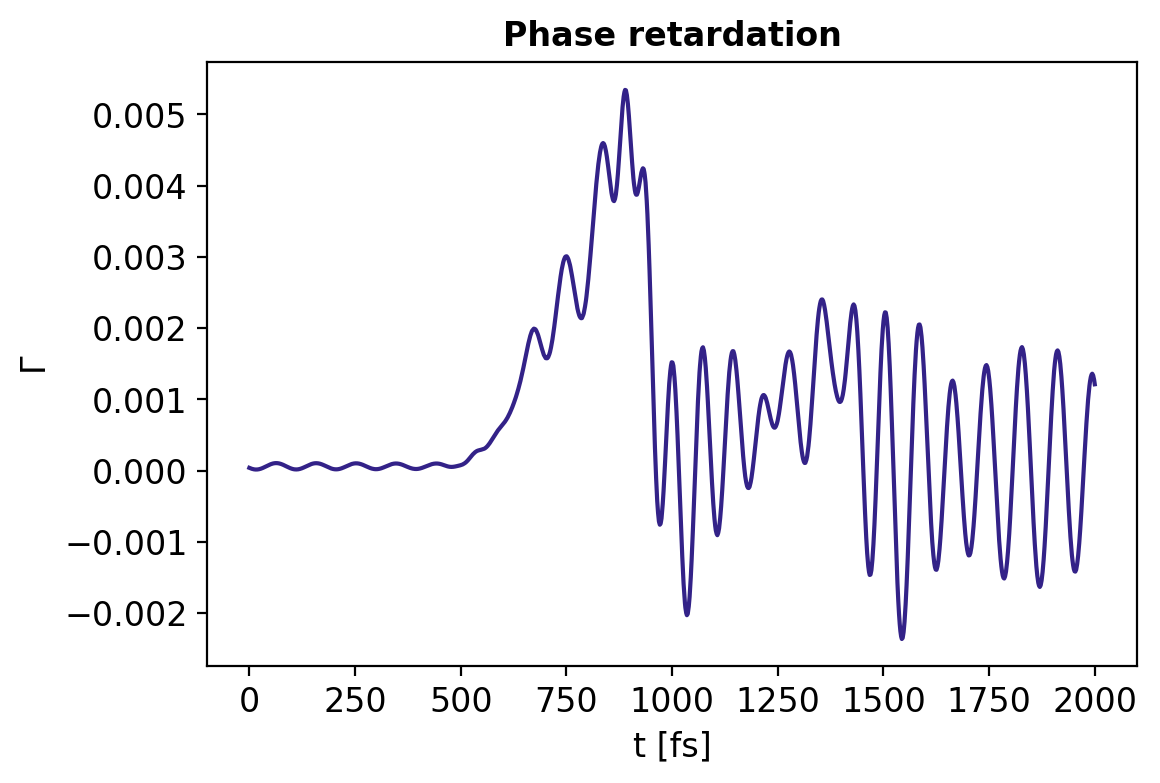

In [4]:
tau = np.linspace(0, 2000, 1000) * 1e-15;
angle = 15 * np.pi / 180;
gamma, t_gamma = pr.phase_retard(Ec, tt*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle, plot = True);

IndexError: too many indices for array

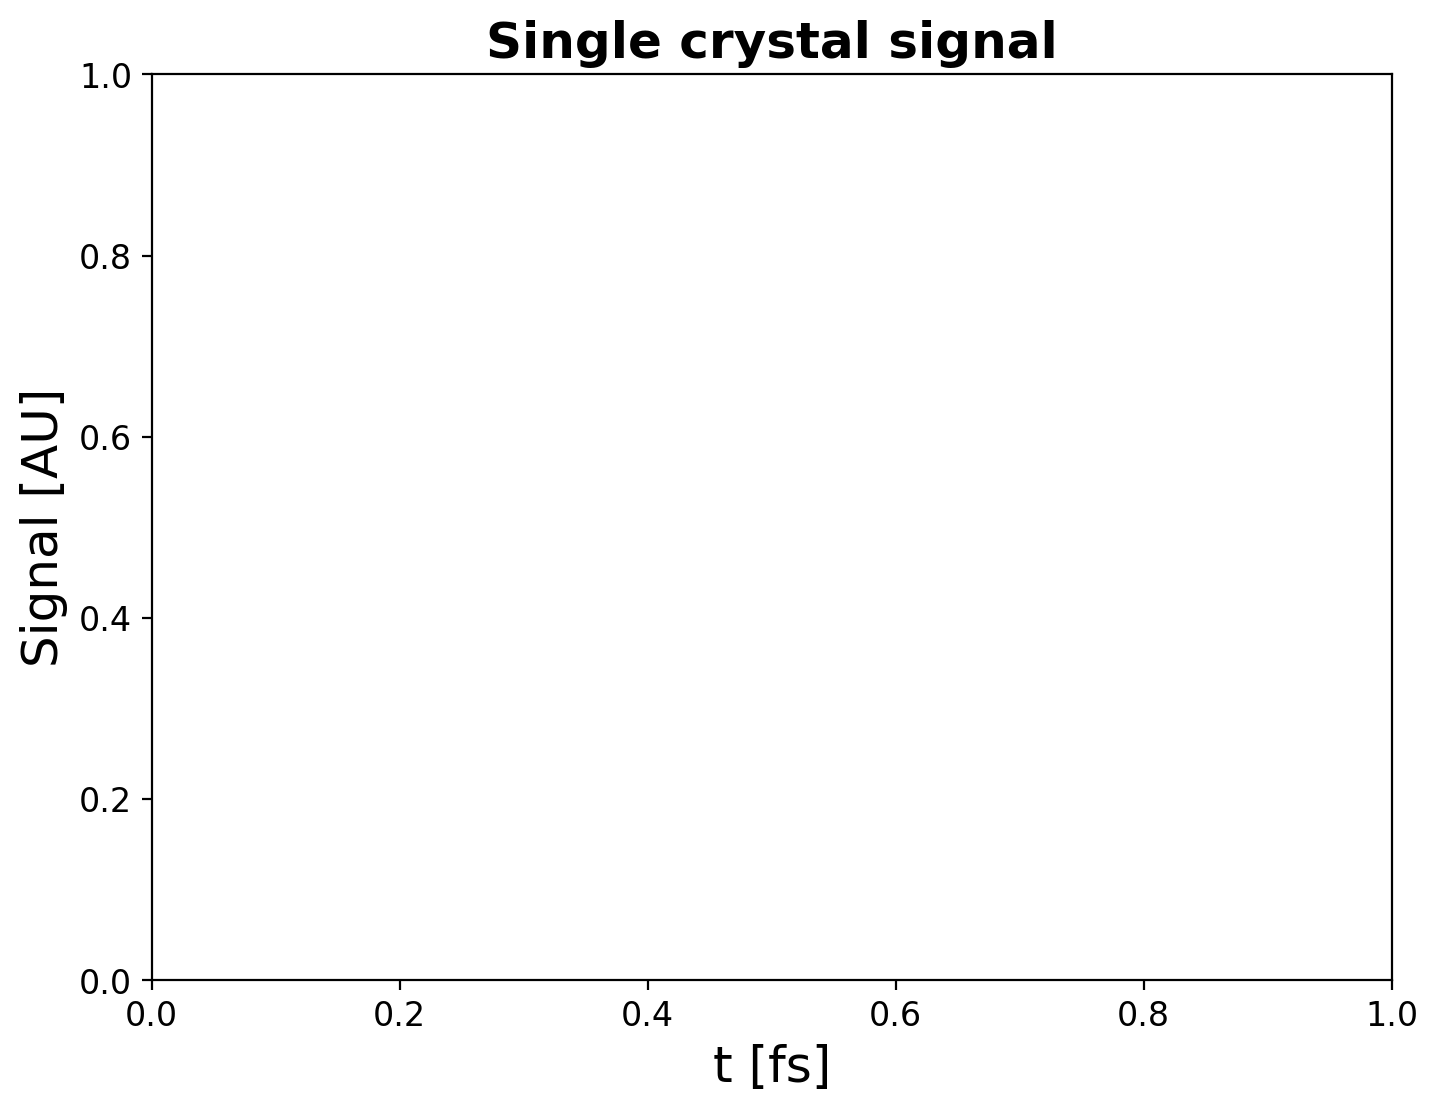

In [5]:
fig, ax = makefig(x = 8, y = 6, xlab = 't [fs]', ylab = 'Signal [AU]', fs = 18, ts = 18, \
                  title = 'Single crystal signal')
sig = np.sin(gamma[:, 0] / 2)**2
sig = sig / np.amax(sig);
ax.plot(t_gamma * 1e15, sig);
fig.savefig('long_example.svg')
plt.show()

In [14]:
from scipy.signal import find_peaks;
find_peaks(sig, height = 0.15)

(array([302, 533]), {'peak_heights': array([1.        , 0.18611173])})

In [16]:
ts = np.array([t_gamma[302], t_gamma[533]]) * 1e15;
ts[1] - ts[0]

462.46246246246255

In [6]:
x_off = np.array([100, 50, 0]) * 1e-6;
r0    = 1.0e-3;
tau   = np.linspace(0, 2000, 1000) * 1e-15;
del_z = 150e-6;
Q_wit = 0.5e-9;
angle = 15 * np.pi / 180;
gamma1 = np.zeros((len(tau), len(x_off)));
gamma2 = np.zeros((len(tau), len(x_off)));
for i in range(len(x_off)):
    print(i+1, "of", len(x_off))
    r1 = r0 + x_off[i];
    drive1 = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r1, 'del_z' : 0});
    wit1   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r1, 'del_z' : del_z});
    FEr1, f1 = thz.raw_field(drive1.Er + wit1.Er, drive1.t);
    Ec1, tt1 = thz.cry_field(drive1.t, FEr1, f1, d, probe, cry, nslice = nslice);
    gamma1[:, i], t_gamma = pr.phase_retard(Ec1, tt1*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);
    
    r2 = r0 - x_off[i];
    drive2 = ebeam({'Q' : Q_drive, 't' : t, 'sigz' : sigz, 'r0' : r2, 'del_z' : 0});
    wit2   = ebeam({'Q' : Q_wit, 't' : t, 'sigz' : sigz, 'r0' : r2, 'del_z' : del_z});
    FEr2, f2 = thz.raw_field(drive2.Er + wit2.Er, drive2.t);
    Ec2, tt2 = thz.cry_field(drive2.t, FEr2, f2, d, probe, cry, nslice = nslice);
    gamma2[:, i], t_gamma = pr.phase_retard(Ec2, tt2*1e-12, d_arr, tau, probe, cry, 'spatial', psi = angle);

1 of 3


AttributeError: 'ebeam' object has no attribute 'Er'

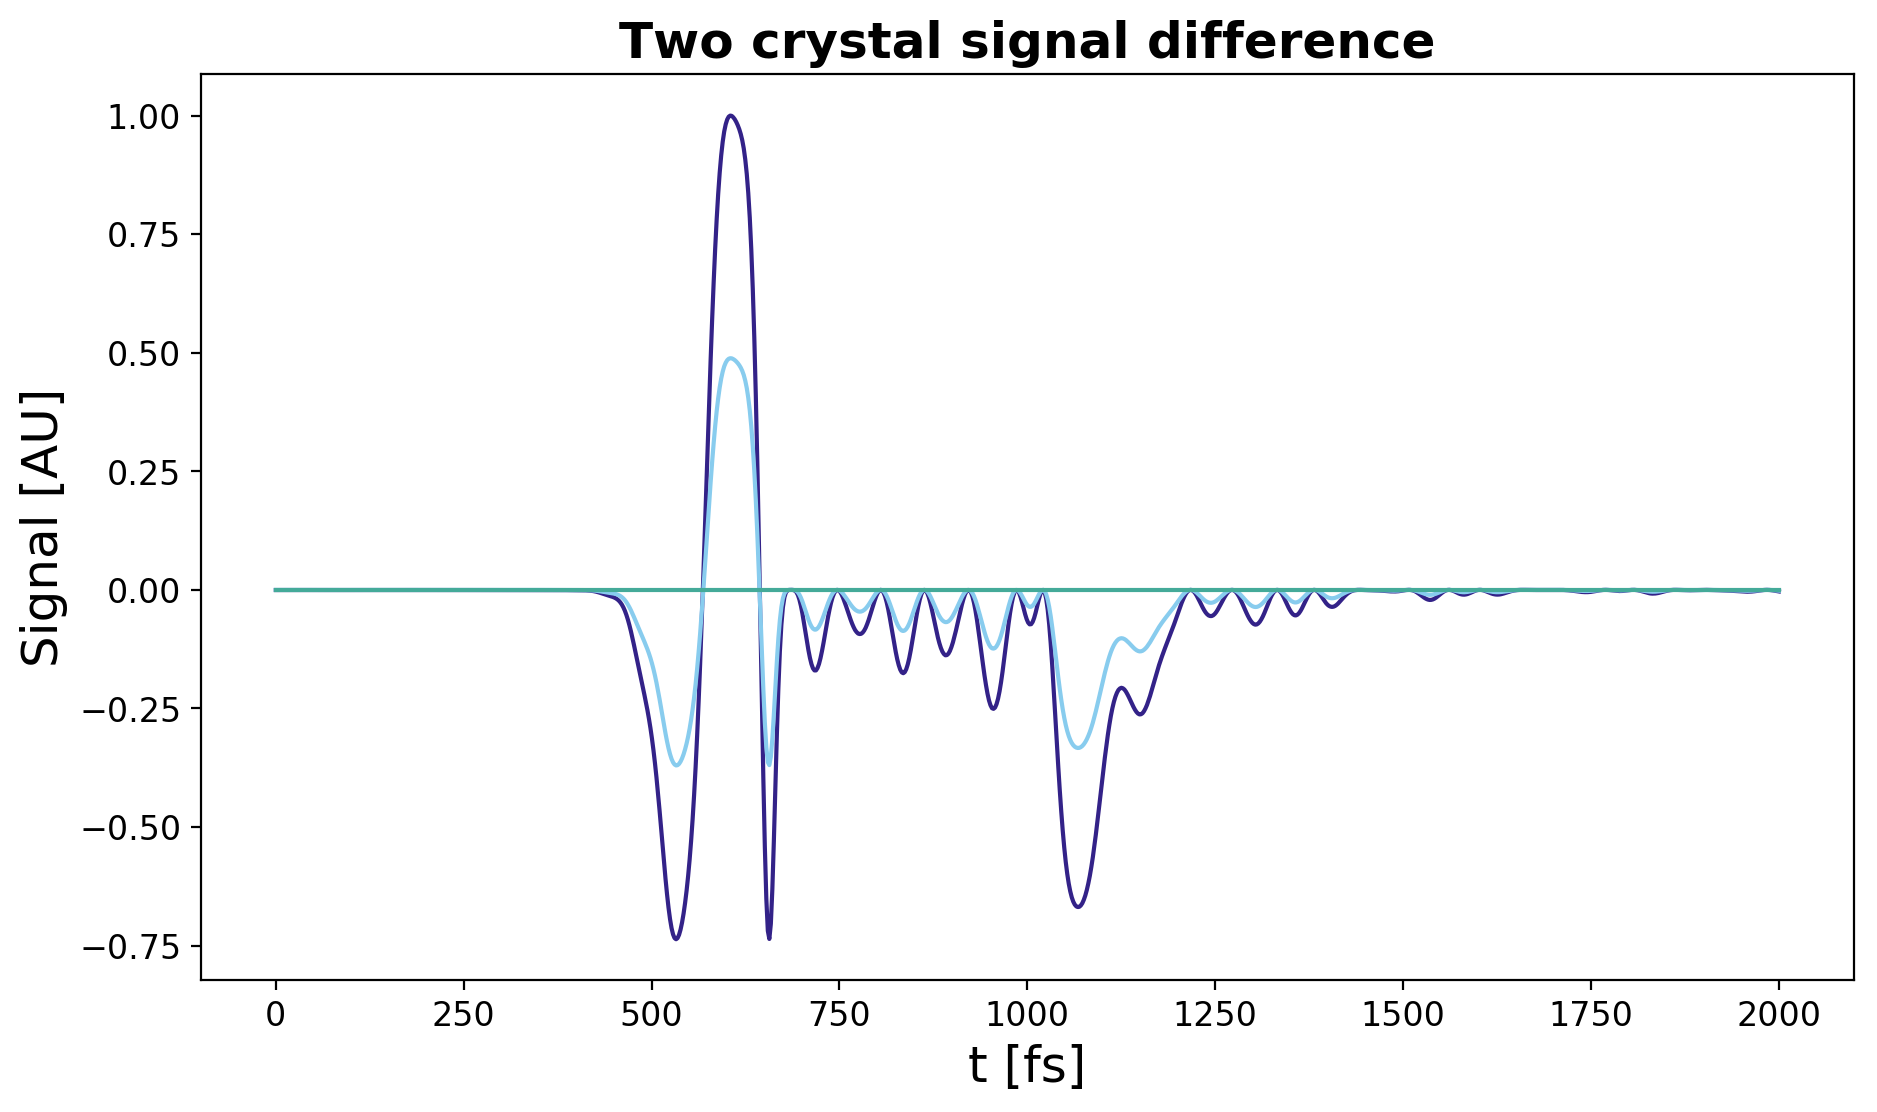

In [6]:
fig, ax = makefig(x = 10.667, y = 6, xlab = 't [fs]', ylab = 'Signal [AU]', fs = 18, ts = 18, \
                 title = 'Two crystal signal difference');
sig1 = np.sin(gamma1 / 2)**2;
sig2 = np.sin(gamma2 / 2)**2;
sig  = sig1 - sig2;
sig  = sig / np.amax(sig)
for i in range(len(x_off)):
    ax.plot(t_gamma * 1e15, sig[:, i]);
#ax.set_xlim([500, 750])
#ax.set_ylim([-1, 1.5])
fig.savefig("trans_example.svg")
plt.show();